## Parameter generation

In [5]:
import yaml
from espei import run_espei
from pycalphad import Database, binplot, equilibrium, variables as v
from espei.datasets import load_datasets, recursive_glob
from espei.plot import dataplot
import matplotlib.pyplot as plt

In [6]:
with open('generate_params_settings.yaml') as fp:
    generate_params_settings = yaml.safe_load(fp)

In [7]:
dbf = run_espei(generate_params_settings)


INFO:espei.espei_script - espei version       0.8.6
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
INFO:espei.paramselect - Generating parameters.
INFO:espei.paramselect - FITTING: BCC_A2
INFO:espei.paramselect - FITTING: FCC_A1
INFO:espei.paramselect - FITTING: HCP_A3
INFO:espei.paramselect - FITTING: LAVES_C14
INFO:espei.paramselect - FITTING: LAVES_C15
INFO:espei.paramselect - FITTING: LAVES_C36
INFO:espei.paramselect - FITTING: LIQUID
INFO:espei.paramselect - Finished generating parameters.


['LIQUID', 'BCC_A2', 'HCP_A3', 'LAVES_C15', 'LAVES_C14', 'LAVES_C36']


<AxesSubplot:title={'center':'HF-MO'}, xlabel='X(HF)', ylabel='Temperature (K)'>

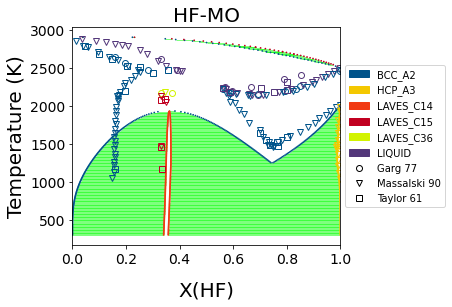

In [8]:
# starting TDB after parameter selection
comps = ['HF', 'MO', 'VA']
phases = ['LIQUID', 'BCC_A2', 'HCP_A3', 'LAVES_C15', 'LAVES_C14', 'LAVES_C36']
#phases = list(dbf.phases.keys())
print(phases)
conds = {v.N: 1.0, v.P: 101325, v.T: (300, 3000, 10), v.X('HF'): (0, 1, 0.01)}
ax = binplot(dbf, comps, phases, conds)
datasets = load_datasets(recursive_glob('input_data/ZPF', '*.json'))
dataplot(comps, phases, conds, datasets, ax=ax)

Now that we have an initial fit to only the derivatives of the Gibbs energy functions, we can judge our initial parameterization against the phase diagram data.

All data is stored in JSON files, so we can load that into an in-memory database of `datasets`.

In [122]:
%matplotlib inline
from pycalphad import Database, calculate, equilibrium, variables as v
dbf = Database('dft.tdb')
comps = ['HF', 'MO', 'VA']
calc_result = calculate(dbf, comps, 'LIQUID', P=101325, T=[2416])
#eq_result = equilibrium(dbf, comps , phases, {v.X('HF'):(0,1,0.05), v.T: (500, 3000, 100), v.P:101325}, output='HM')
#print(eq_result)
print(calc_result.GM[0][0][0][1])

<xarray.DataArray 'GM' ()>
array(-142527.59558091)
Coordinates:
    N        float64 1.0
    P        float64 1.013e+05
    T        float64 2.416e+03


In [115]:
eq_result = equilibrium(dbf, comps ,phases, {v.X('HF'):(0,1,0.1), v.T: (2768), v.P:101325},output='HM')
print(eq_result.GM[0][0][0][1])
print(eq_result.HM[0][0][0][1])

<xarray.DataArray 'GM' ()>
array(-194633.81986114)
Coordinates:
    N        float64 1.0
    P        float64 1.013e+05
    T        float64 2.768e+03
    X_HF     float64 0.1
<xarray.DataArray 'HM' ()>
array(83064.32102624)
Coordinates:
    N        float64 1.0
    P        float64 1.013e+05
    T        float64 2.768e+03
    X_HF     float64 0.1


Then plot the binary phase diagram with these new datasets on the same axes

## Understanding parameter generation

We can use `plot_paramters` to visualize how ESPEI fit our thermochemical data to the parameters

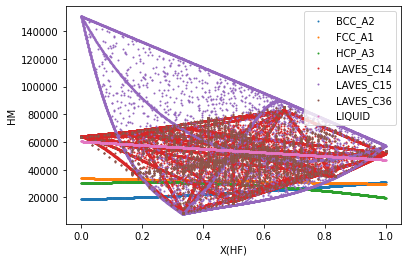

In [12]:
%matplotlib inline
from pycalphad import Database, calculate, equilibrium, variables as v
import matplotlib.pyplot as plt
dbf = Database('dft_origin.tdb')
phases = list(dbf.phases.keys())
for phase_name in phases:
    if phase_name == 'LAVES_C36':
        pdens = 10
    else:
        pdens = 1000
    cr = calculate(dbf, ['MO', 'HF', 'VA'], phase_name, N=1, P=101325, T=1000, pdens=pdens,output='HM')
    plt.scatter(cr.X.sel(component='HF'), cr.HM.squeeze(), label=phase_name, s=1)

#print(cr)
plt.ylabel('HM')
plt.xlabel('X(HF)')
plt.legend()

In [18]:
from espei.plot import plot_endmember

To be more quantitative, the parameters in the pycalphad database can be searched for the excess parameters that were fit.

The mathematical expression for each excess parameter is found in the `parameter` key, i.e. for the first parameter:

$$ {}^{0} L^{\mathrm{LIQUID}} = \mathrm{VV0015} + \mathrm{VV0014} T $$

where $ \mathrm{VV0015} $ are symbols that are generated by ESPEI that are fit.